## Problem Set #5

MACS 30150, Dr. Evans

Ruoyun Tan

In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.integrate as intgr
import numpy.linalg as lin

### Problem 1

#### (a)

Text(0, 0.5, 'Percent of incomes')

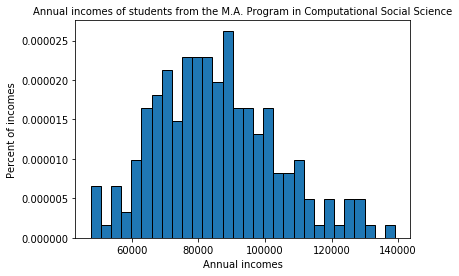

In [2]:
incomes = np.loadtxt("data/incomes.txt")
num_bins = 30
plt.hist(incomes, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of students from the M.A. Program in Computational Social Science', fontsize=10)
plt.xlabel('Annual incomes')
plt.ylabel('Percent of incomes')

#### (b)

In [3]:
def data_moments(xvals):
    mean_data = xvals.mean()
    var_data = xvals.var()
    
    return mean_data, var_data

def model_moments(mu, sigma, lb, ub):
    xfx = lambda x: x * sts.lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    (mean_model, m_m_err) = intgr.quad(xfx, lb, ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * sts.lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    (var_model, v_m_err) = intgr.quad(x2fx, lb, ub)
    
    return mean_model, var_model

def err_vec(xvals, mu, sigma, lb, ub, simple):
    mean_data, var_data = data_moments(xvals)
    data_mts = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma, lb, ub)
    model_mts = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = model_mts - data_mts
    else:
        err_vec = (model_mts - data_mts) / data_mts
    
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    xvals, lb, ub, W = args
    err = err_vec(xvals, mu, sigma, lb, ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (incomes, 0, 150000, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14, method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM, sig_GMM = results.x
print('mu_GMM =', mu_GMM, ' sig_GMM =', sig_GMM)
results

mu_GMM = 11.336910398126385  sig_GMM = 0.21302706281885134


      fun: array([[4.08080238e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.58066719e-13, -8.47624422e-13])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 12
   status: 0
  success: True
        x: array([11.3369104 ,  0.21302706])

Text(0, 0.5, 'Percent of incomes')

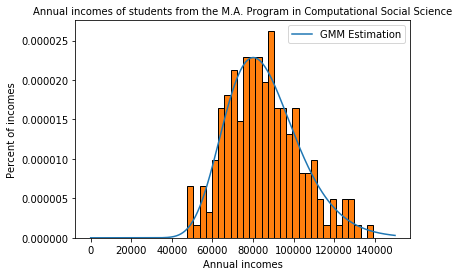

In [4]:
xvals = np.linspace(0, 150000, 10000)
probs = sts.lognorm.pdf(xvals, s=sig_GMM, scale=np.exp(mu_GMM))
plt.plot(xvals, probs, label='GMM Estimation')
plt.legend(loc='upper right')
plt.hist(incomes, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of students from the M.A. Program in Computational Social Science', fontsize=10)
plt.xlabel('Annual incomes')
plt.ylabel('Percent of incomes')

In [5]:
print("The value of GMM criterion function at the estimated parameter values:", results.fun)

The value of GMM criterion function at the estimated parameter values: [[4.08080238e-15]]


In [7]:
mu_model, var_model = model_moments(mu_GMM, sig_GMM, 0, 150000)
mu_data, var_data = data_moments(incomes)
print("The model moments are: mu =", mu_model, ", variance =", var_model)
print("The data moments are: mu =", mu_data, ", variance =", var_data)

The model moments are: mu = 85276.82775093177 , variance = 323731558.8089455
The data moments are: mu = 85276.82360625811 , variance = 323731572.2295289


We can see that the data moments and the model moments are really close.

#### (c)

In [8]:
def get_Err_mat2(xvals, mu, sigma, lb, ub, simple):

    R = 2
    N = len(xvals)
    Err_mat = np.zeros((R, N))
    mean_model, var_model = model_moments(mu, sigma, lb, ub)
    if simple:
        Err_mat[0, :] = incomes - mean_model
        Err_mat[1, :] = ((mu_data - incomes) ** 2) - var_model
    else:
        Err_mat[0, :] = (incomes - mean_model) / mean_model
        Err_mat[1, :] = (((mu_data - incomes) ** 2) - var_model) / var_model
    
    return Err_mat

In [9]:
Err_mat = get_Err_mat2(incomes, mu_GMM, sig_GMM, 0, 150000, False)
VCV2 = (1 / len(incomes)) * (Err_mat @ Err_mat.T)
W_hat2 = lin.inv(VCV2)
print(W_hat2)

[[24.98774403 -1.20073265]
 [-1.20073265  0.57115986]]


In [10]:
params_init = np.array([mu_GMM, sig_GMM])
gmm_args = (incomes, 0, 150000, W_hat2)
results1 = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results1.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)
print("The value of the GMM criterion function at the estimated parameter values:", results1.fun)

mu_GMM2= 11.336910398126385  sig_GMM2= 0.21302706281885134
The value of the GMM criterion function at the estimated parameter values: [[6.48465345e-14]]


Text(0, 0.5, 'Percent of incomes')

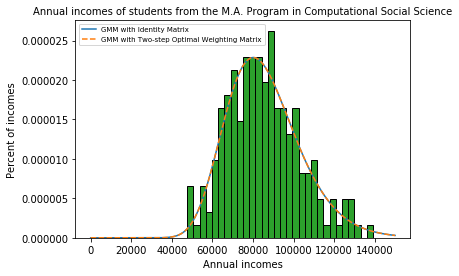

In [11]:
xvals = np.linspace(0, 150000, 10000)
probs1 = sts.lognorm.pdf(xvals, s=sig_GMM, scale=np.exp(mu_GMM))
plt.plot(xvals, probs1, label='GMM with Identity Matrix')
probs2 = sts.lognorm.pdf(xvals, s=sig_GMM2, scale=np.exp(mu_GMM2))
plt.plot(xvals, probs1, linestyle='--', label='GMM with Two-step Optimal Weighting Matrix')
plt.legend(loc='upper left', fontsize=7)
plt.hist(incomes, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of students from the M.A. Program in Computational Social Science', fontsize=10)
plt.xlabel('Annual incomes')
plt.ylabel('Percent of incomes')

In [12]:
print("The value of GMM criterion function at the estimated parameter values:", results1.fun)

The value of GMM criterion function at the estimated parameter values: [[6.48465345e-14]]


In [13]:
mu_model, var_model = model_moments(mu_GMM2, sig_GMM2, 0, 150000)
mu_data, var_data = data_moments(incomes)
print("The model moments are: mu =", mu_model, ", variance =", var_model)
print("The data moments are: mu =", mu_data, ", variance =", var_data)

The model moments are: mu = 85276.82775093177 , variance = 323731558.8089455
The data moments are: mu = 85276.82360625811 , variance = 323731572.2295289


We can see that the data moments and the model moments generated using two-step matrix are also really close.

#### (d)

In [14]:
def data_moments3(xvals):
    data_percent1 = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    data_percent2 = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] / xvals.shape[0])
    data_percent3 = (xvals[xvals >=100000].shape[0] / xvals.shape[0])

    return data_percent1, data_percent2, data_percent3


def model_moments3(mu, sigma):
    xfx = lambda x: sts.lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    (model_percent1, err1) = intgr.quad(xfx, 0, 75000)
    (model_percent2, err2) = intgr.quad(xfx, 75000, 100000)
    (model_percent3, err3) = intgr.quad(xfx, 100000, +np.inf)
    
    return model_percent1, model_percent2, model_percent3


def err_vec3(xvals, mu, sigma, simple):
    data_percent1, data_percent2, data_percent3 = data_moments3(xvals)
    data_moments = np.array([[data_percent1], [data_percent2], [data_percent3]])
    model_percent1, model_percent2, model_percent3 = model_moments3(mu, sigma)
    model_moments = np.array([[model_percent1], [model_percent2], [model_percent3]])
    if simple:
        err_vec = model_moments - data_moments 
    else:
        err_vec = (model_moments - data_moments) / data_moments
    
    return err_vec


def criterion3(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [15]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(3)
gmm_args = (incomes, W_hat)
results2 = opt.minimize(criterion3, params_init, args=(gmm_args), tol=1e-14, method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM3, sig_GMM3 = results2.x
print('mu_GMM3 =', mu_GMM3, ' sig_GMM3 =', sig_GMM3)
results2

/Users/ruoyuntan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  del sys.path[0]


mu_GMM3 = 11.335681327424783  sig_GMM3 = 0.2105984537206961


      fun: array([[2.53378825e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.51707495e-13, -9.99133333e-14])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 63
      nit: 10
   status: 0
  success: True
        x: array([11.33568133,  0.21059845])

Text(0, 0.5, 'Percent of incomes')

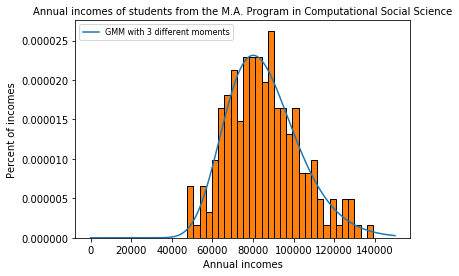

In [16]:
xvals = np.linspace(0, 150000, 10000)
probs3 = sts.lognorm.pdf(xvals, s=sig_GMM3, scale=np.exp(mu_GMM3))
plt.plot(xvals, probs3, label='GMM with 3 different moments')
plt.legend(loc='upper left', fontsize=8)
plt.hist(incomes, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of students from the M.A. Program in Computational Social Science', fontsize=10)
plt.xlabel('Annual incomes')
plt.ylabel('Percent of incomes')

In [17]:
print("The value of GMM criterion function at the estimated parameter values:", results2.fun)

The value of GMM criterion function at the estimated parameter values: [[2.53378825e-15]]


In [18]:
model_percent1, model_percent2, model_percent3 = model_moments3(mu_GMM3, sig_GMM3)
data_percent1, data_percent2, data_percent3 = data_moments3(incomes)
print("The model moments are: Less than $75000 =", model_percent1, ", Between $75000 and $100000 =", model_percent2, ", More than $100000 =", model_percent3)
print("The data moments are: Less than $75000 =", data_percent1, ", Between $75000 and $100000 =", data_percent2, ", More than $100000 =", data_percent3)

The model moments are: Less than $75000 = 0.3000000036326679 , Between $75000 and $100000 = 0.5000000058543148 , More than $100000 = 0.19999999051301745
The data moments are: Less than $75000 = 0.3 , Between $75000 and $100000 = 0.5 , More than $100000 = 0.2


We can see that the data moments and the model moments are again really close.

#### (e)

In [19]:
def get_Err_mat3(xvals, mu, sigma, simple):
    R = 3
    N = len(xvals)
    Err_mat = np.zeros((R, N))
    model_percent1, model_percent2, model_percent3 = model_moments3(mu, sigma)
    if simple:
        xvals_in_grp1 = (xvals < 75000)
        Err_mat[0, :] = xvals_in_grp1 - model_percent1
        xvals_in_grp2 = (xvals >= 75000) & (xvals < 100000)
        Err_mat[1, :] = xvals_in_grp2 - model_percent2
        xvals_in_grp3 = (xvals >= 100000)
        Err_mat[2, :] = xvals_in_grp3 - model_percent3
    else:
        xvals_in_grp1 = (xvals < 75000)
        Err_mat[0, :] = (xvals_in_grp1 - model_percent1) / model_percent1
        xvals_in_grp2 = (xvals >= 75000) & (xvals < 100000)
        Err_mat[1, :] = (xvals_in_grp2 - model_percent2) / model_percent2
        xvals_in_grp3 = (xvals >= 100000)
        Err_mat[2, :] = (xvals_in_grp3 - model_percent3) / model_percent3
    
    return Err_mat

In [20]:
Err_mat3 = get_Err_mat3(incomes, mu_GMM3, sig_GMM3, simple=False)
VCV3_2 = (1 / incomes.shape[0]) * (Err_mat3 @ Err_mat3.T)
W_hat3_2 = lin.inv(VCV3_2)
print(W_hat3_2)

[[9.67011391e+13 1.61168565e+14 6.44674222e+13]
 [1.61168565e+14 2.68614275e+14 1.07445704e+14]
 [6.44674222e+13 1.07445704e+14 4.29782789e+13]]


In [21]:
params_init = np.array([mu_GMM3, sig_GMM3])
gmm_args = (incomes, W_hat3_2)
results3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM3_2, sig_GMM3_2 = results3.x
print('mu_GMM3_2=', mu_GMM3_2, ' sig_GMM3_2=', sig_GMM3_2)
print("The value of the GMM criterion function at the estimated parameter values:", results3.fun)

mu_GMM3_2= 11.335681327424783  sig_GMM3_2= 0.2105984537206961
The value of the GMM criterion function at the estimated parameter values: [[1.10678717e-15]]


Text(0, 0.5, 'Percent of incomes')

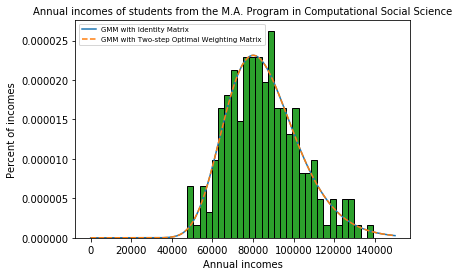

In [22]:
xvals = np.linspace(0, 150000, 10000)
probs3 = sts.lognorm.pdf(xvals, s=sig_GMM3, scale=np.exp(mu_GMM3))
plt.plot(xvals, probs3, label='GMM with Identity Matrix')
probs3_2 = sts.lognorm.pdf(xvals, s=sig_GMM3_2, scale=np.exp(mu_GMM3_2))
plt.plot(xvals, probs3_2, linestyle='--', label='GMM with Two-step Optimal Weighting Matrix')
plt.legend(loc='upper left', fontsize=7)
plt.hist(incomes, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of students from the M.A. Program in Computational Social Science', fontsize=10)
plt.xlabel('Annual incomes')
plt.ylabel('Percent of incomes')

In [23]:
print("The value of GMM criterion function at the estimated parameter values:", results3.fun)

The value of GMM criterion function at the estimated parameter values: [[1.10678717e-15]]


In [24]:
model_percent1, model_percent2, model_percent3 = model_moments3(mu_GMM3_2, sig_GMM3_2)
data_percent1, data_percent2, data_percent3 = data_moments3(incomes)
print("The model moments are: Less than $75000 =", model_percent1, ", Between $75000 and $100000 =", model_percent2, ", More than $100000 =", model_percent3)
print("The data moments are: Less than $75000 =", data_percent1, ", Between $75000 and $100000 =", data_percent2, ", More than $100000 =", data_percent3)

The model moments are: Less than $75000 = 0.3000000036326679 , Between $75000 and $100000 = 0.5000000058543148 , More than $100000 = 0.19999999051301745
The data moments are: Less than $75000 = 0.3 , Between $75000 and $100000 = 0.5 , More than $100000 = 0.2


Again, we can see that the data moments and the model moments generated using two-step matrix are really close.

#### (f)

All four methods produce very close model moments and they are all close to the data moments. Comparing the value of GMM criterion function, we can see that the estimates in (f) where we used 4 moments and the two-step matrix give the smallest value of the GMM criterion function. In this sense, I think the estimates in (f) fits the data best.

### Problem 2

In [25]:
sick_data = np.loadtxt("data/sick.txt", delimiter=',', skiprows=1)
sick_data = sick_data.transpose()

In [26]:
def data_moments(data):
    return data[0]

def model_moments(beta0, beta1, beta2, beta3):
    return beta0 + beta1 * sick_data[1] + beta2 * sick_data[2] + beta3 * sick_data[3]

def errs(data, beta0, beta1, beta2, beta3):
    model_mts = model_moments(beta0, beta1, beta2, beta3)
    
    return data_moments(data) - model_mts

def crit(params, *args):
    beta0, beta1, beta2, beta3 = params
    data, W = args
    err = errs(data, beta0, beta1, beta2, beta3)
    crit_val = err.T @ W @ err 
    
    return crit_val


params_init = np.array([0.1, 0, 0, 0])
W_hat = np.eye(200)
gmm_args = (sick_data, W_hat)
results = opt.minimize(crit, params_init, args=(gmm_args))
beta0, beta1, beta2, beta3 = results.x
print('beta0 =', beta0, 'beta1 =', beta1, 'beta2 =', beta2, 'beta3 =', beta1)
print("The value of the GMM criterion function is", results.fun)

beta0 = 0.2516444940499588 beta1 = 0.012933548207441156 beta2 = 0.4005001676487419 beta3 = 0.012933548207441156
The value of the GMM criterion function is 0.0018212897111372112
